In [33]:
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from scipy import signal
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy.random as random
#import cartopy

Create toy data set in space-time [x,y,t].  We start with random noise in [x,y], and then multiply it by a weighting function to make it a bit more similar to geophysical data. Then, we create a linear trend along the time dimension, add some noise to simulate interannual variability, and apply the trend to each x,y gridpoint. 

(50, 100, 10000)


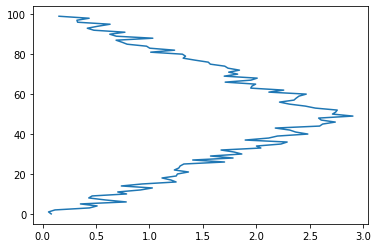

In [73]:
time_range = np.arange(0,10000)
x_dim = 50
y_dim = 100
time_dim = 10000
#Create initial x-y array from random noise
noise_space_uwt = random.random([x_dim,y_dim,time_dim])
#apply wts in the x-direction to better emulate geophysical space.
#We'll create a weighting function and then add a bit of noise 
y_wts = np.concatenate((np.arange(0,y_dim/2),np.arange(y_dim/2,0,-1)))/(y_dim*0.1)
y_wts = y_wts + random.random([y_dim,])
noise_space = y_wts[None,:,None]*noise_space_uwt
#Plot average over y and time, we should see a triangle (values in the middle weigh more)
plt.plot(np.nanmean(np.nanmean(noise_space,axis=2),axis=0),np.arange(0,y_dim))
#Now, we add a first-order trend in time.  First we create the equation (and add some random noise). 
trend_slope = 0.01 #slope of trend
trend_int = 0.001 #intercept of trend
#We create a line with the slope and intercept we defined, and then we add some random noise
trend_eqn = trend_slope*np.arange(0,time_dim) + 5*random.random([time_dim,])
#Now, apply the trend to each spatial gridpoint
trend_3d = trend_eqn[None,None,:]*noise_space
data_detrend = signal.detrend(trend_3d,axis=2)
print(data_detrend.shape)
xg,yg = np.meshgrid(np.arange(0,x_dim),np.arange(0,y_dim))

Now, plot the spatial average of our trended data.  We should see the data increasing with time, but it should have some wiggles from the noise we added 

Text(0.5, 1.0, 'Spatial average of our data with a linear trend')

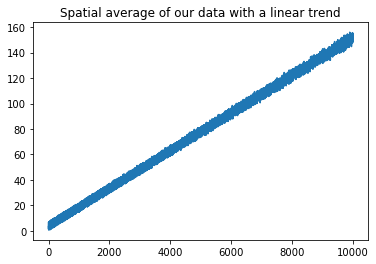

In [37]:
plt.plot(np.nanmean(np.nanmean(trend_3d,axis=1),axis=0))
plt.title('Spatial average of our data with a linear trend')

Remove the time mean from each grid cell.  With geophysical data, we'd want to remove a seasonal average.  For example, January temperatures in Texas are naturally more variable than July temperatures (January can be warmish or chilly, July is always hot).  So, we want to account for this in our preprocessing (note that there are a lot of ways to do this; exactly what you'd do would depend on your scientific problem and the time resolution of your data).  Here, we will just take a mean in time and remove that to create an anomaly time series. 

Text(0.5, 1.0, 'Spatial average of our data, time-mean removed')

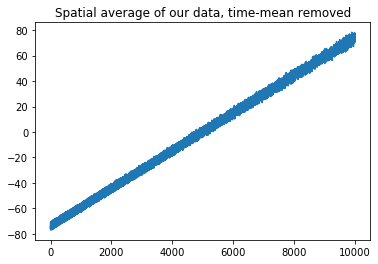

In [38]:
time_mean = np.nanmean(trend_3d,axis=2)
time_anom = trend_3d - time_mean[:,:,None]
plt.plot(np.nanmean(np.nanmean(time_anom,axis=1),axis=0))
plt.title('Spatial average of our data, time-mean removed')

Now, following Hawkins and Sutton (2012), we'll create a global mean.  We're going to average our data in X and Y to simulate a global mean time series. With geophysical data, we'd typically want to include an area weighting, usually cos(latitude), since a grid cell at the equator is more spatially extensive than one at the pole. Here, we will just assume our grid cells have equal area.

In [39]:
time_mean = np.nanmean(np.nanmean(time_anom,axis=1),axis=0)

Create smoothed version of our global (spatially averaged) time series.  We want to capture the trend over our full time domain while smoothing out some of the wiggles that are happening on shorter timescales.  Here, we'll approximate our smoothed time series with a first-order polynomial using numpy's polyfit function.
We note that we're cheating a bit--we created this synthetic data with a linear trend, so we know that it's best approximated with a linear trend.  We note that Hawkins and Sutton do this with a 4-th order polynomial, because this best captures the overall time series of global mean surface temperature. As you can imagine, you might want to use a different smoothing approach that better approximates your specific data.

Text(0.5, 1.0, 'Comparison of raw and smoothed spatially-averaged data')

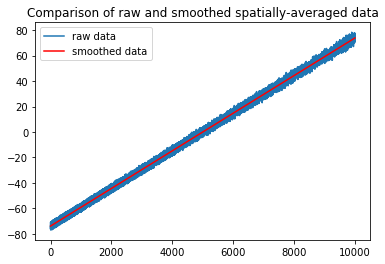

In [40]:
#Fit a first-order polynomial to our spatially-averaged data
smoothed_coefs = np.polyfit(time_range,time_mean,1)
smoothed_vals = np.poly1d(smoothed_coefs)
#Apply polynomial over our time domain
data_smoothed = smoothed_vals(time_range)
#plot our spatially averaged data (blue), and our smoothed data (red)
plt.plot(time_range,time_mean)
plt.plot(time_range,data_smoothed,'r')
plt.legend(['raw data','smoothed data'])
plt.title('Comparison of raw and smoothed spatially-averaged data')

Now, we use linear regression to explore the question, "What portion of the variability at each gridpoint can be explained by the trend?".  We're assuming that our smoothed global mean time series is a good approximation of our trend, and we'll regress this time series (our predictor) on our data at each gridpoint.  For this example, we'll use the OLS package in statsmodel, but you could use any package that can perform a straightforward linear regression.  We want our regression model to output 2 things at each gridpoint--a regression coefficient, alpha (a slope), and the residuals, beta (an intercept).  
Note that if we apply our OLS model to our anomaly data, our alphas (slopes), should be approximately zero; this will change if we apply our OLS model to the raw data.  Our betas (intercepts), should be the same either way. First we'll just do an example at a single gridpoint

In [91]:
time_anom.shape
#To get the intercept coefficients, we need to use add_constant
x_regress_example = sm.OLS(time_anom[33,2,:],sm.tools.add_constant(data_smoothed)).fit()
x_regress_example.params
#version with raw data
#x_regress_example = sm.OLS(trend_3d[33,2,:],sm.tools.add_constant(data_smoothed)).fit()
#x_regress_example.params
print("alpha: ",x_regress_example.params[0],"   beta: ",x_regress_example.params[1])
print(x_regress_example.summary())

alpha:  3.3306690738754696e-15    beta:  0.17494072331673582
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     7141.
Date:                Thu, 17 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:45:31   Log-Likelihood:                -35971.
No. Observations:               10000   AIC:                         7.195e+04
Df Residuals:                    9998   BIC:                         7.196e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

Apply regression to each gridpoint.  I am unsophisticated and tired so I am going to do two loops, the matlab way.  Obviously this is dumb and can probably be avoided with some kind of unraveling function but we will fix this tomorrow. 

In [92]:
alphas_all = np.zeros([x_dim,y_dim])
betas_all = np.zeros([x_dim,y_dim])
for i in np.arange(0,x_dim):
    for j in np.arange(0,y_dim):
        ij_regress = sm.OLS(time_anom[i,j,:],sm.tools.add_constant(data_smoothed)).fit()
        alphas_all[i,j] = ij_regress.params[0]
        betas_all[i,j] = ij_regress.params[1]

Plot our alphas and our betas as a function of space

Text(0.5, 1.0, 'betas')

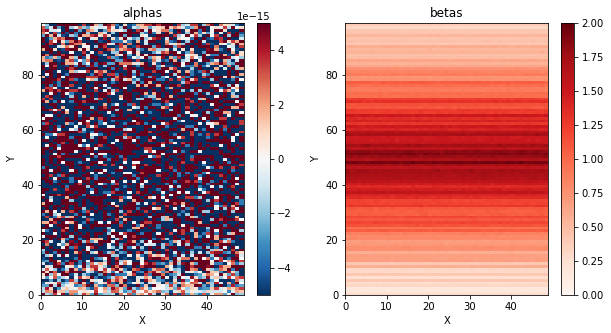

In [95]:
fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
xgrid,ygrid = np.meshgrid(np.arange(0,x_dim),np.arange(0,y_dim))
pc1 = ax1.pcolormesh(xgrid,ygrid,np.transpose(alphas_all),cmap='RdBu_r',vmin=-5e-15,vmax=5e-15)
fig1.colorbar(pc1,ax=ax1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
pc2 = ax2.pcolormesh(xgrid,ygrid,np.transpose(betas_all),cmap='Reds',vmin=0,vmax=2)
fig1.colorbar(pc2,ax=ax2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax1.set_title('alphas')
ax2.set_title('betas')
#print(xgrid.shape)
#print(alphas_all.shape)

Now, let's estimate noise.  We'll keep it basic and call our "noise" the standard deviation of our anomaly time series at each gridpoint.  This should roughly represent how big the wiggles around the red line (smoothed data) are

spatially averaged standard deviation is  0.857528364326181


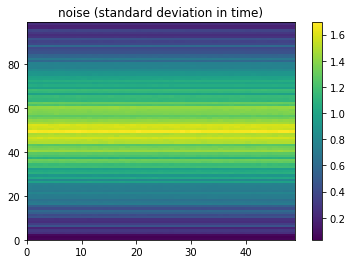

In [96]:
noise = np.nanstd(noise_space,axis=2) #should have dimensions of x,y

noiseplot = plt.pcolormesh(xgrid,ygrid,np.transpose(noise))
plt.colorbar(noiseplot)
plt.title('noise (standard deviation in time)')
print('spatially averaged standard deviation is ',np.nanmean(np.nanmean(noise)))

Now, we estimate our signal to noise ratio. The signal is estimated from our regression coefficients, and the noise is estimated above (standard dev).  We'll do a really naive prediction here and just do an in-sample prediction.  In a real analysis, we'd probably want to divide things into training and testing data. 


In [125]:
data_test_to_predict = sm.add_constant(time_anom[4,63,2999:-1])
print("dependent variable has shape of ",time_anom[33,2,:].shape)
print("independent variable has shape of ",sm.add_constant(data_smoothed).shape)
print("regression model has shape of ",x_regress_example.params.shape)
print("data to predict has shape of ",data_test_to_predict.shape)
data_prediction = x_regress_example.predict(np.squeeze(data_test_to_predict))
print(data_prediction.shape)

dependent variable has shape of  (10000,)
independent variable has shape of  (10000, 2)
regression model has shape of  (2,)
data to predict has shape of  (7000, 2)
(7000,)


Text(0.5, 1.0, 'comparison of actual data and prediction from regression')

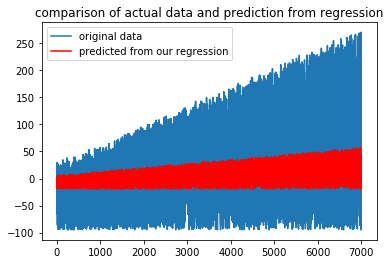

In [127]:

plt.plot(time_anom[4,33,2999:-1])
plt.plot(data_prediction,'r')
plt.legend(['original data','predicted from our regression'])
plt.title('comparison of actual data and prediction from regression')

Finally, we compare the signal (red line in the above plot) to the noise to see when/if S > N

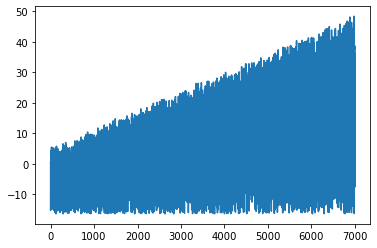

In [130]:
sig_noise = data_prediction/noise[4,33]
plt.plot(sig_noise)